In [168]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from tqdm import tqdm

In [253]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler

In [40]:
import xgboost as xgb
import optuna

In [219]:
from cuml.svm import SVC
from cuml.neighbors import KNeighborsClassifier

In [41]:
plot_params = {
    'font.family': 'Ubuntu',
    'font.weight': 'light',
    
    'figure.figsize': (5,5),
    'figure.frameon': False, 
    'figure.titlesize': 'xx-large',
    'figure.titleweight': 'normal',
    
    'axes.titlesize': 'large',
    'axes.titlecolor': 'black',
    'axes.titleweight': 'normal',
    'axes.titlelocation': 'center',
    'axes.labelsize': 'x-large',
    
    'grid.alpha': .25, 
    'legend.frameon':False,
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large',
}

pylab.rcParams.update(plot_params)
sns.set_palette('mako')

In [42]:
RANDOM_STATE = 7

In [43]:
data_folder = 'data'
train_data_fname = 'train.csv'
test_data_fname = 'test.csv'
external_data_fname = 'external_data.csv'
sample_submission_fname = 'sample_submission.csv'


train_data_path = os.path.join(data_folder, train_data_fname)
test_data_path = os.path.join(data_folder, test_data_fname)
external_data_path = os.path.join(data_folder, external_data_fname)
sample_data_path = os.path.join(data_folder, sample_submission_fname)

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
external_data = pd.read_csv(external_data_path)
sample_data = pd.read_csv(sample_data_path)

In [44]:
set(external_data.columns.tolist()).difference(train_data.columns.tolist())

set()

In [45]:
train_data.calc.max()

14.34

In [46]:
test_data.gravity.max()

1.034

In [47]:
train_data.target.value_counts() / train_data.__len__()

0    0.555556
1    0.444444
Name: target, dtype: float64

In [48]:
train_data.calc.between(2.5, 7.5, inclusive='both').value_counts()

False    253
True     161
Name: calc, dtype: int64

In [49]:
original_features = train_data.drop(['id', 'target'], axis=1).columns.tolist()
original_features

['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']

In [120]:
def add_features(df):
    # Binary features for normal ranges
    # https://www.kaggle.com/competitions/playground-series-s3e12/discussion/399409
    
    df['gravity_normal'] = df.gravity.between(1.005, 1.03,inclusive='both').astype(int)

    df['ph_ideal'] = df.ph.between(6, 7.5, inclusive='both').astype(int)

    df['urea_normal'] = df.urea.between(428, 714, inclusive='both').astype(int)

    df['calc_normal'] = df.calc.between(2.5,7.5, inclusive='both').astype(int)


    # df['calc'] = df.calc.clip(None, 8)
    # df['gravity'] = df.gravity.clip(None, 1.04)

    # Ratio of calcium concentration to urea concentration: 
    df['calc_urea_ratio'] = df['calc'] / df['urea']

    # Ratio of specific gravity to osmolarity: 
    df['gravity_osm_ratio'] = df['gravity'] / df['osmo']

    # Product of calcium concentration and osmolarity: 
    df['calc_osm_product'] = df['calc'] * df['osmo']

    # Product of specific gravity and conductivity: 
    df['gravity_cond_product'] = df['gravity'] * df['cond']

    # Ratio of gravity and conductivity
    df['gravity_cond_ratio'] = df['gravity'] / df['cond']

    # Ratio of calcium concentration to specific gravity: 
    df['calc_gravity_ratio'] = df['calc'] / df['gravity']

    # Ratio of urea concentration to specific gravity: 
    df['urea_gravity_ratio'] = df['urea'] / df['gravity']

    # Product of osmolarity and conductivity: 
    df['osm_cond_product'] = df['osmo'] * df['cond']

    # Ratio of calcium concentration to osmolarity: 
    df['calc_osm_ratio'] = df['calc'] / df['osmo']

    # Ratio of urea concentration to osmolarity: 
    df['urea_osm_ratio'] = df['urea'] / df['osmo']

    # Product of specific gravity and urea concentration: 
    df['gravity_urea_product'] = df['gravity'] * df['urea']

    return df 


In [57]:
add_features(train_data)

,id,gravity,ph,osmo,cond,urea,calc,target,gravity_normal,ph_ideal,...,gravity_osm_ratio,calc_osm_product,gravity_cond_product,gravity_cond_ratio,calc_gravity_ratio,urea_gravity_ratio,osm_cond_product,calc_osm_ratio,urea_osm_ratio,gravity_urea_product
0,0,1.013,6.19,443,14.8,124,1.45,0,True,True,...,0.002287,642.35,14.9924,0.068446,1.431392,122.408687,6556.4,0.003273,0.279910,125.612
1,1,1.025,5.40,703,23.6,394,4.18,0,True,False,...,0.001458,2938.54,24.1900,0.043432,4.078049,384.390244,16590.8,0.005946,0.560455,403.850
2,2,1.009,6.13,371,24.5,159,9.04,0,True,True,...,0.002720,3353.84,24.7205,0.041184,8.959366,157.581764,9089.5,0.024367,0.428571,160.431
3,3,1.021,4.91,442,20.8,398,6.63,1,True,False,...,0.002310,2930.46,21.2368,0.049087,6.493634,389.813908,9193.6,0.015000,0.900452,406.358
4,4,1.021,5.53,874,17.8,385,2.21,1,True,False,...,0.001168,1931.54,18.1738,0.057360,2.164545,377.081293,15557.2,0.002529,0.440503,393.085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,409,1.011,5.21,527,21.4,75,1.53,0,True,False,...,0.001918,806.31,21.6354,0.047243,1.513353,74.183976,11277.8,0.002903,0.142315,75.825
410,410,1.024,5.53,577,19.7,224,0.77,0,True,False,...,0.001775,444.29,20.1728,0.051980,0.751953,218.750000,11366.9,0.001334,0.388215,229.376
411,411,1.018,6.28,455,22.2,270,7.68,1,True,True,...,0.002237,3494.40,22.5996,0.045856,7.544204,265.225933,10101.0,0.016879,0.593407,274.860
412,412,1.008,7.12,325,12.6,75,1.03,1,True,True,...,0.003102,334.75,12.7008,0.080000,1.021825,74.404762,4095.0,0.003169,0.230769,75.600


In [62]:
X = train_data[original_features].copy()
Y = train_data['target']

# X['calc'] = X.calc.clip(None, 8)
# X['gravity'] = X.gravity.clip(None, 1.03)
# X['calc_gravity_ratio'] = X['calc'] / X['gravity']
# X['calc_urea_ratio'] = X['calc'] / X['urea']
# X['gravity_cond_ratio'] = X['gravity'] / X['cond']

In [52]:
test_data['calc'] = test_data.calc.clip(None, 8)
test_data['gravity'] = test_data.gravity.clip(None, 1.03)
test_data['calc_gravity_ratio'] = test_data['calc'] / test_data['gravity']
test_data['calc_urea_ratio'] = test_data['calc'] / test_data['urea']
test_data['gravity_cond_ratio'] = test_data['gravity'] / test_data['cond']

In [93]:
# cv_scores, roc_auc_scores = list(), list()

# skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
# for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

#     X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#     Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

#     model = 

#     model_pred_1 = model.predict_proba(X_test)  
#     score = roc_auc_score(Y_test, model_pred_1)
#     roc_auc_scores.append(score)

#     print('Fold', i, '==> roc-auc-score is ==>', score)


In [154]:
def objective(trial):
   
    params = {
        "n_estimators": trial.suggest_int('n_estimators', 25, 1000, 25), 
        "verbosity": 0,
        "tree_method": "gpu_hist",
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 100.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 100.0, log=True),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "max_depth": trial.suggest_int("max_depth", 2, 10, step=1),
        # minimum child weight, larger the term more conservative the tree.
        "min_child_weight": trial.suggest_float(
            "min_child_weight", 1e-8, 100, log=True
        ),
        "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
        # defines how selective algorithm is.
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy": "depthwise",
        "eval_metric": "aucpr",
    }
    rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)
    roc_auc_scores = []

    clf = xgb.XGBClassifier(**params)

    for i, (train_index, val_index) in enumerate(rskf.split(X, Y)):
        X_train, Y_train = X.loc[train_index], Y.loc[train_index]
        X_val, Y_val = X.loc[val_index], Y.loc[val_index]
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict_proba(X_val)[:,1]
        score = roc_auc_score(Y_val, Y_pred)

    roc_auc_scores.append(score)
    return np.mean(roc_auc_scores)

In [158]:
study = optuna.create_study(direction = 'maximize')

[I 2023-04-13 01:32:57,607] A new study created in memory with name: no-name-1971acb1-abe9-4a80-b9c9-a373fda65eab


In [160]:
study.optimize(objective, n_trials = 1000)

[I 2023-04-13 01:34:52,324] Trial 5 finished with value: 0.7971014492753622 and parameters: {'n_estimators': 525, 'lambda': 0.018048882066446194, 'alpha': 2.4355038144543317e-07, 'colsample_bytree': 0.31107111747392313, 'max_depth': 5, 'min_child_weight': 0.11139011823630286, 'learning_rate': 0.14071923198677558, 'gamma': 0.059398340628566214}. Best is trial 3 with value: 0.9009661835748792.
[I 2023-04-13 01:35:46,225] Trial 6 finished with value: 0.7451690821256038 and parameters: {'n_estimators': 975, 'lambda': 3.488493167139217, 'alpha': 0.04788172525273399, 'colsample_bytree': 0.8144016407772272, 'max_depth': 7, 'min_child_weight': 0.00038136084436982674, 'learning_rate': 2.608523928839664e-07, 'gamma': 0.2361986077465635}. Best is trial 3 with value: 0.9009661835748792.
[I 2023-04-13 01:36:33,552] Trial 7 finished with value: 0.6570048309178744 and parameters: {'n_estimators': 700, 'lambda': 0.0003942991157434652, 'alpha': 0.0006047080349586043, 'colsample_bytree': 0.4913997849430

In [99]:
study.best_params

{'n_estimators': 775,
 'lambda': 0.0199176239138371,
 'alpha': 0.01742770013170134,
 'colsample_bytree': 0.4158597554520956,
 'max_depth': 4,
 'min_child_weight': 45.65479967791505,
 'learning_rate': 0.014582622226156005,
 'gamma': 9.521796611796531e-05}

In [161]:
study.best_params

{'n_estimators': 125,
 'lambda': 1.7356199494986414e-08,
 'alpha': 0.0019071485541771686,
 'colsample_bytree': 0.5209583465745184,
 'max_depth': 3,
 'min_child_weight': 4.6244812967077635e-07,
 'learning_rate': 8.541852751545541e-06,
 'gamma': 7.4268265248206e-05}

In [162]:
study.best_value

0.9722222222222222

In [100]:
study.best_value

0.47705314009661837

In [106]:
best_params = study.trials[436].params

In [63]:
best_params_new_study = {
        'n_estimators': 125,
        'lambda': 1.7356199494986414e-08,
        'alpha': 0.0019071485541771686,
        'colsample_bytree': 0.5209583465745184,
        'max_depth': 3,
        'min_child_weight': 4.6244812967077635e-07,
        'learning_rate': 8.541852751545541e-06,
        'gamma': 7.4268265248206e-05
}

In [64]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=100)
roc_auc_scores = []

clf = xgb.XGBClassifier(**best_params_new_study)

for i, (train_index, val_index) in enumerate(rskf.split(X, Y)):
    X_train, Y_train = X.loc[train_index], Y.loc[train_index]
    X_val, Y_val = X.loc[val_index], Y.loc[val_index]

    X_train = add_features(X_train)
    X_val = add_features(X_val)
    
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict_proba(X_val)[:,1]
    score = roc_auc_score(Y_val, Y_pred)
    roc_auc_scores.append(score)

print(f"Min:\t\t{np.min(roc_auc_scores)}")
print(f"Max:\t\t{np.max(roc_auc_scores)}")
print(f"Mean:\t\t{np.mean(roc_auc_scores)}")

Min:		0.5471014492753624
Max:		0.9541062801932366
Mean:		0.7775480549199085


In [163]:
# old_scores = roc_auc_scores

In [176]:
# old_scores
print(f"Min:\t\t{np.min(old_scores)}")
print(f"Max:\t\t{np.max(old_scores)}")
print(f"Mean:\t\t{np.mean(old_scores)}")

Min:		0.5579710144927537
Max:		0.9855072463768116
Mean:		0.7959140605136029


In [177]:
# v1
print(f"Min:\t\t{np.min(roc_auc_scores)}")
print(f"Max:\t\t{np.max(roc_auc_scores)}")
print(f"Mean:\t\t{np.mean(roc_auc_scores)}")

Min:		0.5537757437070938
Max:		0.9748283752860412
Mean:		0.7861390795830154


In [65]:
# v2
print(f"Min:\t\t{np.min(roc_auc_scores)}")
print(f"Max:\t\t{np.max(roc_auc_scores)}")
print(f"Mean:\t\t{np.mean(roc_auc_scores)}")

Min:		0.5471014492753624
Max:		0.9541062801932366
Mean:		0.7775480549199085


In [67]:
# v1_scores = roc_auc_scores
v2_scores = roc_auc_scores

In [ ]:
# With added features

(array([  2.,   2.,   2.,   2.,   9.,  10.,  13.,  34.,  47.,  55.,  66.,
         74.,  92.,  98., 103.,  92.,  80.,  77.,  46.,  38.,  27.,  21.,
          5.,   4.,   1.]),
 array([0.55377574, 0.57061785, 0.58745995, 0.60430206, 0.62114416,
        0.63798627, 0.65482838, 0.67167048, 0.68851259, 0.70535469,
        0.7221968 , 0.7390389 , 0.75588101, 0.77272311, 0.78956522,
        0.80640732, 0.82324943, 0.84009153, 0.85693364, 0.87377574,
        0.89061785, 0.90745995, 0.92430206, 0.94114416, 0.95798627,
        0.97482838]),
 [<matplotlib.patches.Polygon at 0x7f4c40c39df0>])

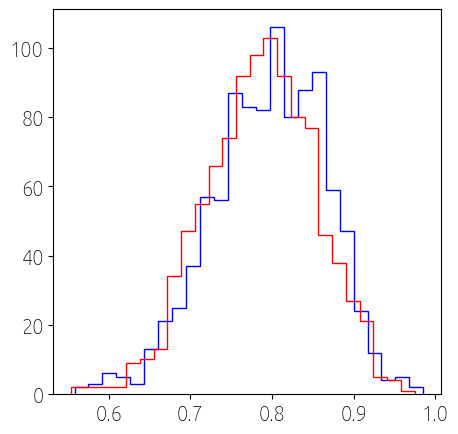

In [175]:

plt.hist(old_scores, edgecolor = 'blue', bins = 25, color = 'blue', histtype = 'step', label = 'v0')
plt.hist(roc_auc_scores, edgecolor = 'red', bins = 25, color = 'purple', histtype = 'step', label = 'v1')

For now, I cannot really trust the cv score as the second tuned model, performed better on the public leaderboard although having a lower cv score.

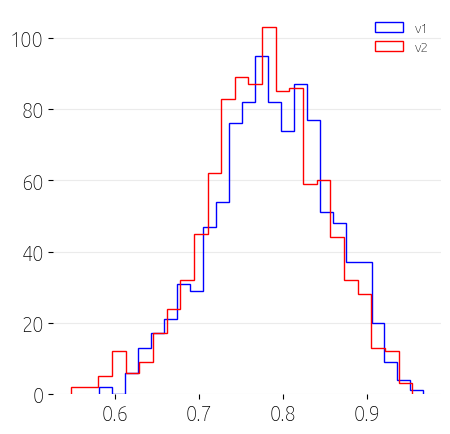

In [71]:
plt.hist(v1_scores, edgecolor = 'blue', bins = 25, color = 'blue', histtype = 'step', label = 'v1')
plt.hist(v2_scores, edgecolor = 'red', bins = 25, color = 'purple', histtype = 'step', label = 'v2')
plt.box(False)
plt.grid(axis = 'y')
plt.legend()
plt.show()

In [77]:
X, Y = train_data.loc[:, original_features], train_data.loc[:, 'target']

In [78]:
X = add_features(X)

In [79]:
model = xgb.XGBClassifier(**best_params_new_study)

In [80]:
model.fit(X, Y)

XGBClassifier(alpha=0.0019071485541771686, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5209583465745184, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=7.4268265248206e-05, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              lambda=1.7356199494986414e-08,
              learning_rate=8.541852751545541e-06, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0,
              min_child_weight=4.6244812967077635e-07, missing=nan,
              monotone_constraints='()', n_estimators=125, n_jobs=0,
              num_parallel_tree=1, ...)

In [93]:
feature_importances_ = zip(X.columns.to_list(), model.feature_importances_)

In [94]:
feature_importances_ = sorted(feature_importances_, key = lambda x: x[1])
feature_names, feature_importances = list(zip(*feature_importances_))

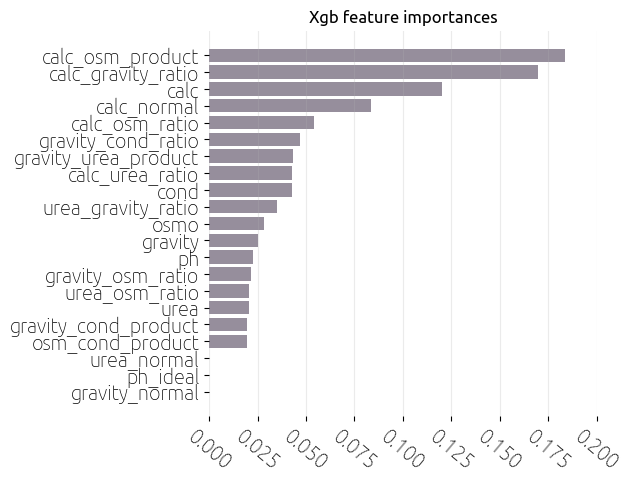

In [108]:
plt.barh(y = feature_names, width = feature_importances, alpha = .5)
plt.title('Xgb feature importances')
plt.box()
plt.xticks(np.linspace(0,.20, 9), rotation = 320)
plt.grid(axis = 'x')

#### SVM

In [161]:
def objective(trial):
   
    params = {
        'C':trial.suggest_int('C', 1, 2e2),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'degree': trial.suggest_int('degree', 2,4),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'probability':True
    }
    rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)
    roc_auc_scores = []

    clf = SVC(**params)
    for i, (train_index, val_index) in enumerate(rskf.split(X, Y)):
        X_train, Y_train = X.loc[train_index], Y.loc[train_index]
        X_val, Y_val = X.loc[val_index], Y.loc[val_index]
        

        X_train = add_features(X_train)
        X_val = add_features(X_val)

        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        clf.fit(X_train, Y_train)
        Y_pred = clf.predict_proba(X_val)[:,1]
        score = roc_auc_score(Y_val, Y_pred)

        roc_auc_scores.append(score)
    return np.mean(roc_auc_scores)

In [160]:
svm_study = optuna.create_study(direction = 'maximize')

[I 2023-04-13 15:36:44,508] A new study created in memory with name: no-name-0d466344-b614-4521-b03d-f72a01f0d572


In [162]:
svm_study.optimize(objective, n_trials=1500)

[I 2023-04-13 15:37:15,585] Trial 0 finished with value: 0.6291507754894482 and parameters: {'C': 151, 'kernel': 'sigmoid', 'degree': 2, 'gamma': 'scale'}. Best is trial 0 with value: 0.6291507754894482.
[I 2023-04-13 15:39:28,725] Trial 1 finished with value: 0.7877955758962624 and parameters: {'C': 189, 'kernel': 'linear', 'degree': 2, 'gamma': 'auto'}. Best is trial 1 with value: 0.7877955758962624.
[I 2023-04-13 15:40:14,753] Trial 2 finished with value: 0.7863107042969741 and parameters: {'C': 64, 'kernel': 'linear', 'degree': 2, 'gamma': 'auto'}. Best is trial 1 with value: 0.7877955758962624.
[I 2023-04-13 15:41:30,726] Trial 3 finished with value: 0.7861988304093568 and parameters: {'C': 108, 'kernel': 'linear', 'degree': 2, 'gamma': 'scale'}. Best is trial 1 with value: 0.7877955758962624.
[I 2023-04-13 15:44:12,198] Trial 4 finished with value: 0.6559750826341215 and parameters: {'C': 131, 'kernel': 'poly', 'degree': 4, 'gamma': 'scale'}. Best is trial 1 with value: 0.7877955

RuntimeError: The work in this thread was cancelled.
Obtained 64 stack frames
#0 in /home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/pylibraft/common/handle.cpython-39-x86_64-linux-gnu.so(+0x297bf) [0x7f5126d447bf]
#1 in /home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/pylibraft/common/handle.cpython-39-x86_64-linux-gnu.so(+0x1c381) [0x7f5126d37381]
#2 in /home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/zmq/backend/cython/_device.cpython-39-x86_64-linux-gnu.so(+0x694e) [0x7f52edc6094e]
#3 in /home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/cuml/svm/svc.cpython-39-x86_64-linux-gnu.so(+0x289f4) [0x7f50fb0639f4]
#4 in /home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/cuml/svm/svc.cpython-39-x86_64-linux-gnu.so(+0x3c153) [0x7f50fb077153]
#5 in /home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/cuml/svm/svc.cpython-39-x86_64-linux-gnu.so(+0x3f461) [0x7f50fb07a461]
#6 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(PyObject_Call+0x157) [0x56287f47f997]
#7 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyEval_EvalFrameDefault+0x407d) [0x56287f46290d]
#8 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(+0x12a8b7) [0x56287f45d8b7]
#9 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyFunction_Vectorcall+0xb9) [0x56287f46fe09]
#10 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(+0x14c231) [0x56287f47f231]
#11 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyEval_EvalFrameDefault+0x407d) [0x56287f46290d]
#12 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(+0x12a8b7) [0x56287f45d8b7]
#13 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyFunction_Vectorcall+0xb9) [0x56287f46fe09]
#14 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(PyObject_Call+0xb4) [0x56287f47f8f4]
#15 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyEval_EvalFrameDefault+0x407d) [0x56287f46290d]
#16 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(+0x12a8b7) [0x56287f45d8b7]
#17 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyFunction_Vectorcall+0xb9) [0x56287f46fe09]
#18 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyObject_FastCallDictTstate+0x1a5) [0x56287f467575]
#19 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyObject_Call_Prepend+0x69) [0x56287f47c459]
#20 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(+0x21e805) [0x56287f551805]
#21 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(PyObject_Call+0x157) [0x56287f47f997]
#22 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyEval_EvalFrameDefault+0x407d) [0x56287f46290d]
#23 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(+0x12a8b7) [0x56287f45d8b7]
#24 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyFunction_Vectorcall+0xb9) [0x56287f46fe09]
#25 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyEval_EvalFrameDefault+0x3bf) [0x56287f45ec4f]
#26 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(+0x13d113) [0x56287f470113]
#27 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyObject_FastCallDictTstate+0xc1) [0x56287f467491]
#28 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyObject_Call_Prepend+0x69) [0x56287f47c459]
#29 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(+0x21e805) [0x56287f551805]
#30 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyObject_MakeTpCall+0x347) [0x56287f467db7]
#31 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyEval_EvalFrameDefault+0x4ac5) [0x56287f463355]
#32 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(+0x13d113) [0x56287f470113]
#33 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyObject_FastCallDictTstate+0xc1) [0x56287f467491]
#34 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(+0x148a78) [0x56287f47ba78]
#35 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyObject_MakeTpCall+0x35e) [0x56287f467dce]
#36 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyEval_EvalFrameDefault+0x4ac5) [0x56287f463355]
#37 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(+0x12a8b7) [0x56287f45d8b7]
#38 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(+0x14c198) [0x56287f47f198]
#39 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyEval_EvalFrameDefault+0x11e0) [0x56287f45fa70]
#40 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(+0x13d113) [0x56287f470113]
#41 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyEval_EvalFrameDefault+0x66e) [0x56287f45eefe]
#42 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(+0x13d113) [0x56287f470113]
#43 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyEval_EvalFrameDefault+0x66e) [0x56287f45eefe]
#44 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(+0x12a8b7) [0x56287f45d8b7]
#45 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyObject_FastCallDictTstate+0x140) [0x56287f467510]
#46 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyObject_Call_Prepend+0x69) [0x56287f47c459]
#47 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(+0x21e805) [0x56287f551805]
#48 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyObject_MakeTpCall+0x347) [0x56287f467db7]
#49 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyEval_EvalFrameDefault+0x4ac5) [0x56287f463355]
#50 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(+0x12a8b7) [0x56287f45d8b7]
#51 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyEval_EvalCodeWithName+0x47) [0x56287f45d577]
#52 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(PyEval_EvalCodeEx+0x39) [0x56287f45d529]
#53 in /home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/cuml/svm/svc.cpython-39-x86_64-linux-gnu.so(+0x2358e) [0x7f50fb05e58e]
#54 in /home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/cuml/svm/svc.cpython-39-x86_64-linux-gnu.so(+0x2b4b9) [0x7f50fb0664b9]
#55 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(PyObject_Call+0x157) [0x56287f47f997]
#56 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyEval_EvalFrameDefault+0x407d) [0x56287f46290d]
#57 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(+0x12a8b7) [0x56287f45d8b7]
#58 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(_PyEval_EvalCodeWithName+0x47) [0x56287f45d577]
#59 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(PyEval_EvalCodeEx+0x39) [0x56287f45d529]
#60 in /home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/cuml/svm/svc.cpython-39-x86_64-linux-gnu.so(+0x2358e) [0x7f50fb05e58e]
#61 in /home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/cuml/svm/svc.cpython-39-x86_64-linux-gnu.so(+0x39974) [0x7f50fb074974]
#62 in /home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/cuml/svm/svc.cpython-39-x86_64-linux-gnu.so(+0x3f461) [0x7f50fb07a461]
#63 in /home/mikhailtal/mambaforge/envs/rapids@22.12/bin/python(PyObject_Call+0x157) [0x56287f47f997]



[32m[I 2023-04-14 02:55:43,930][0m Trial 467 finished with value: 0.7925781845919146 and parameters: {'C': 160, 'kernel': 'linear', 'degree': 4, 'gamma': 'auto'}. Best is trial 467 with value: 0.7925781845919146.[0m

In [164]:
svm_params_1 = {'C': 160, 'kernel': 'linear', 'degree': 4, 'gamma': 'auto', 'probability': True}

In [133]:
X = add_features(train_data)

In [134]:
model.fit(X, Y)

SVC()

In [166]:
X = train_data[original_features].copy()
Y = train_data['target']

In [218]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10)
roc_auc_scores = []
    
clf = SVC(**svm_params_1)
for i, (train_index, val_index) in tqdm(enumerate(rskf.split(X, Y))):
    X_train, Y_train = X.loc[train_index], Y.loc[train_index]
    X_val, Y_val = X.loc[val_index], Y.loc[val_index]

    # X_train = add_features(X_train)
    # X_val = add_features(X_val)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    clf.fit(X_train, Y_train)
    Y_pred = clf.predict_proba(X_val)
    score = roc_auc_score(Y_val, Y_pred[:,1])
    roc_auc_scores.append(score)

print(f"Min:\t\t{np.min(roc_auc_scores)}")
print(f"Max:\t\t{np.max(roc_auc_scores)}")
print(f"Mean:\t\t{np.mean(roc_auc_scores)}")

100it [03:42,  2.22s/it]

Min:		0.6594202898550725
Max:		0.9267734553775744
Mean:		0.785252987541317


In [222]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=100)
roc_auc_scores = []
    
clf = KNeighborsClassifier()
for i, (train_index, val_index) in tqdm(enumerate(rskf.split(X, Y))):
    X_train, Y_train = X.loc[train_index], Y.loc[train_index]
    X_val, Y_val = X.loc[val_index], Y.loc[val_index]

    # X_train = add_features(X_train)
    # X_val = add_features(X_val)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    clf.fit(X_train, Y_train)
    Y_pred = clf.predict_proba(X_val)
    score = roc_auc_score(Y_val, Y_pred[:,1])
    roc_auc_scores.append(score)

print(f"Min:\t\t{np.min(roc_auc_scores)}")
print(f"Max:\t\t{np.max(roc_auc_scores)}")
print(f"Mean:\t\t{np.mean(roc_auc_scores)}")

1000it [00:04, 216.86it/s]

Min:		0.47025171624713963
Max:		0.919908466819222
Mean:		0.7481656496313247


SVM performed considerably worse on the public leaderboard

#### Knn

In [223]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [224]:

X = train_data[original_features].copy()
Y = train_data['target']

In [228]:
def objective(trial):
    # -- Instantiate scaler
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
                
    # -- Tune estimator algorithm
    n_neighbors = trial.suggest_int("n_neighbors", 1, 30)
    # weights = trial.suggest_categorical("weights", ['uniform', 'distance'])
    metric = trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski'])
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights='uniform', metric=metric)
        
    # -- Make a pipeline
    pipeline = make_pipeline(scaler, knn)

    # -- Cross-validate the features reduced by dimensionality reduction methods
    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)
    score = cross_val_score(
        pipeline, 
        X, Y, 
        scoring = make_scorer(roc_auc_score, greater_is_better=True, needs_proba = True), 
        cv=kfold)
    score = score.mean()
    return score


In [229]:
knn_study = optuna.create_study(direction = 'maximize')

[I 2023-04-14 18:33:10,810] A new study created in memory with name: no-name-9017a9dd-257a-4863-b423-a8d5e4789ec7


In [231]:
knn_study.optimize(objective, n_trials=1000)

[I 2023-04-14 18:33:32,664] Trial 3 finished with value: 0.753235443681668 and parameters: {'scalers': 'robust', 'n_neighbors': 6, 'metric': 'euclidean'}. Best is trial 2 with value: 0.7723086702262902.
[I 2023-04-14 18:33:32,891] Trial 4 finished with value: 0.7299529621154335 and parameters: {'scalers': 'minmax', 'n_neighbors': 4, 'metric': 'euclidean'}. Best is trial 2 with value: 0.7723086702262902.
[I 2023-04-14 18:33:37,105] Trial 5 finished with value: 0.7685430968726165 and parameters: {'scalers': 'minmax', 'n_neighbors': 10, 'metric': 'manhattan'}. Best is trial 2 with value: 0.7723086702262902.
[I 2023-04-14 18:33:41,400] Trial 6 finished with value: 0.7582901093312993 and parameters: {'scalers': 'robust', 'n_neighbors': 7, 'metric': 'minkowski'}. Best is trial 2 with value: 0.7723086702262902.
[I 2023-04-14 18:33:45,627] Trial 7 finished with value: 0.7878502415458938 and parameters: {'scalers': 'minmax', 'n_neighbors': 24, 'metric': 'manhattan'}. Best is trial 7 with value:

In [232]:
knn_study.optimize(objective, n_trials=500)

[I 2023-04-14 19:42:30,224] Trial 1003 finished with value: 0.7787159928807525 and parameters: {'scalers': 'minmax', 'n_neighbors': 25, 'metric': 'manhattan'}. Best is trial 741 with value: 0.7878896516653954.
[I 2023-04-14 19:42:34,545] Trial 1004 finished with value: 0.7792753623188406 and parameters: {'scalers': 'minmax', 'n_neighbors': 27, 'metric': 'manhattan'}. Best is trial 741 with value: 0.7878896516653954.
[I 2023-04-14 19:42:34,773] Trial 1005 finished with value: 0.7740655987795577 and parameters: {'scalers': 'minmax', 'n_neighbors': 26, 'metric': 'euclidean'}. Best is trial 741 with value: 0.7878896516653954.
[I 2023-04-14 19:42:39,077] Trial 1006 finished with value: 0.7869705059750827 and parameters: {'scalers': 'minmax', 'n_neighbors': 24, 'metric': 'manhattan'}. Best is trial 741 with value: 0.7878896516653954.
[I 2023-04-14 19:42:43,397] Trial 1007 finished with value: 0.7799211797609966 and parameters: {'scalers': 'minmax', 'n_neighbors': 23, 'metric': 'manhattan'}. 

In [235]:
knn_best_params = knn_study.best_params

In [236]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=100)
roc_auc_scores = []
    
clf = KNeighborsClassifier(**knn_best_params)
for i, (train_index, val_index) in tqdm(enumerate(rskf.split(X, Y))):
    X_train, Y_train = X.loc[train_index], Y.loc[train_index]
    X_val, Y_val = X.loc[val_index], Y.loc[val_index]

    # X_train = add_features(X_train)
    # X_val = add_features(X_val)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    clf.fit(X_train, Y_train)
    Y_pred = clf.predict_proba(X_val)
    score = roc_auc_score(Y_val, Y_pred[:,1])
    roc_auc_scores.append(score)

print(f"Min:\t\t{np.min(roc_auc_scores)}")
print(f"Max:\t\t{np.max(roc_auc_scores)}")
print(f"Mean:\t\t{np.mean(roc_auc_scores)}")

1000it [01:28, 11.29it/s]

Min:		0.5289855072463768
Max:		0.9734299516908212
Mean:		0.7804244851258582


In [237]:

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=100)
roc_auc_scores = []
    
clf = KNeighborsClassifier(**knn_best_params)
for i, (train_index, val_index) in tqdm(enumerate(rskf.split(X, Y))):
    X_train, Y_train = X.loc[train_index], Y.loc[train_index]
    X_val, Y_val = X.loc[val_index], Y.loc[val_index]

    X_train = add_features(X_train)
    X_val = add_features(X_val)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    clf.fit(X_train, Y_train)
    Y_pred = clf.predict_proba(X_val)
    score = roc_auc_score(Y_val, Y_pred[:,1])
    roc_auc_scores.append(score)

print(f"Min:\t\t{np.min(roc_auc_scores)}")
print(f"Max:\t\t{np.max(roc_auc_scores)}")
print(f"Mean:\t\t{np.mean(roc_auc_scores)}")

1000it [01:33, 10.72it/s]

Min:		0.5048309178743962
Max:		0.9541062801932367
Mean:		0.7801285278413425


In [258]:
from sklearn.feature_selection import chi2, RFECV
# from cuml.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

#### Logreg

In [252]:
X = train_data[original_features].copy()
Y = train_data['target']

In [259]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10)
roc_auc_scores = []
roc_curves = []    
clf = LogisticRegression()
for i, (train_index, val_index) in tqdm(enumerate(rskf.split(X, Y))):
    X_train, Y_train = X.loc[train_index], Y.loc[train_index]
    X_val, Y_val = X.loc[val_index], Y.loc[val_index]

    # X_train = add_features(X_train)
    # X_val = add_features(X_val)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    clf.fit(X_train, Y_train)
    Y_pred = clf.predict_proba(X_val)
    score = roc_auc_score(Y_val, Y_pred[:,1])
    rc = roc_curve(Y_val, Y_pred[:,1])

    roc_curves.append(rc)
    roc_auc_scores.append(score)

print(f"Min:\t\t{np.min(roc_auc_scores)}")
print(f"Max:\t\t{np.max(roc_auc_scores)}")
print(f"Mean:\t\t{np.mean(roc_auc_scores)}")

100it [00:00, 276.01it/s]

Min:		0.6183574879227054
Max:		0.9178743961352657
Mean:		0.781395881006865


#### Create submission

In [240]:

X = train_data[original_features].copy()
Y = train_data['target']

X_test = test_data[original_features].copy()

In [211]:
# X = add_features(X)
# X_test = add_features(X_test)
# X_cols = X.columns

In [241]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

In [243]:
# model = xgb.XGBClassifier(**best_params_new_study)
# model = SVC(**svm_params_1)
model = KNeighborsClassifier(**knn_best_params)

In [244]:
model.fit(X, Y)

KNeighborsClassifier()

In [245]:
# X.columns

In [246]:
# test_data.columns

In [247]:
X.shape, X_test.shape

((414, 6), (276, 6))

In [248]:
# X_test.loc[:, X_cols]

In [249]:
preds = model.predict_proba(X_test)

In [250]:
sample_data.loc[:, 'target'] = preds[:,1]

In [251]:
sample_data.to_csv('predictions/knn_1.csv', index =False)